In [1]:
from pyzx.rules import*
import pyzx as zx
import random
from pyzx.graph.base import BaseGraph, VT, ET
from typing import List, Callable, Optional, Union, Generic, Tuple, Dict, Iterator, cast
from typing import TypeVar
from copy import deepcopy

spider_simp: 3. 1. 1. 1. 1.  5 iterations


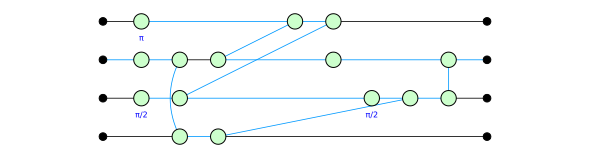

In [2]:
# Rewrite_match と同じ回路なので比較してみましょう。
qubit = 4
depth = 15
random.seed(22)
circ = zx.generate.CNOT_HAD_PHASE_circuit(qubit, depth, clifford=True)
g1 = circ.to_graph()
zx.simplify.spider_simp(g1)
zx.simplify.to_gh(g1)
zx.draw_matplotlib(g1)

In [3]:
MatchObject = TypeVar("MatchObject")
RewriteOutputType = Tuple[Dict[Tuple[VT,VT],List[int]], List[VT], List[ET], bool]


## Clifford Simp
Clifford_match_functions = [match_ids_parallel, match_spider_parallel, match_pivot_parallel, match_lcomp_parallel]
Clifford_rewrite_functions = [remove_ids, spider, pivot, lcomp]

In [4]:
def search_all_simp_match(
    g:BaseGraph[VT, ET],
    match_funcions: List[Callable[..., List[MatchObject]]],
) -> Dict[str, List[MatchObject]]:
    all_results = {}
    # Execute match-search methods and store them
    for match_func in match_funcions:
        results = match_func(g)
        all_results[match_func.__name__] = results
    
    for name, result in all_results.items():
        print(f"Results for {name}: {result}")
    
    return all_results

多分、幅優先探索的になると思われます。

In [26]:
def apply_simp(
    g:BaseGraph[VT, ET],
    rewrite_function:Callable[..., List[MatchObject]],
    match:List[MatchObject],
):
    g1 = deepcopy(g)
    etab, rem_verts, rem_edges, check_isolated_vertices = \
    rewrite_function(g,match)
    g1.add_edge_table(etab)
    g1.remove_edges(rem_edges)
    g1.remove_vertices(rem_verts)
    if check_isolated_vertices: g1.remove_isolated_vertices()
    return g1

class ActionNode:
    def __init__(self,  
    rewrited_graph, applied_match = None, applied_rewrite = None) -> None:
        self.graph = rewrited_graph
        self.applied_match = applied_match
        self.applied_rewrite = applied_rewrite
        self.children = []
    
    def add_childnode(self, childnode):
        self.children.append(childnode)
    
    def __repr__(self) -> str:
        pass

class ActionTree:
    def __init__(self, initial_graph) -> None:
        self.root = ActionNode(initial_graph)
        self.current_node = self.root
    
    def add_action_result(self, match_results, rewrite_functions):
        # current_node について、match_results から childnode を作る
        i = 0
        for key, matches in match_results.items():
            for j in range(len(matches)):
                g1 = deepcopy(self.current_node.graph)
                g2 = apply_simp(g1, rewrite_functions[i], [matches[j]])
                new_node = ActionNode(g2, [matches[j]], rewrite_functions[i])
                self.current_node.add_childnode(new_node)
            i += 1
    
    def set_current_node(self, node):
        self.current_node = node
    
    def show(self, node = None, level = 0):
        if node is None:
            node = self.root
        print("  " * level + f"Applied Rewrite: {node.applied_rewrite}, Applied Match: {node.applied_match}, Graph : {node.graph.__class__}")
        for child in node.children:
            self.show(child, level+1)

In [27]:
action_tree = ActionTree(g1)
action_tree.show()

Applied Rewrite: None, Applied Match: None, Graph : <class 'pyzx.graph.graph_s.GraphS'>


In [28]:
results = search_all_simp_match(g1, Clifford_match_functions)
print(action_tree.current_node.graph)
print(results.items())

Results for match_ids_parallel: [(4, 1, 5, 1), (23, 24, 11, 1)]
Results for match_spider_parallel: [(5, 11)]
Results for match_pivot_parallel: [(21, 25, [], [28]), (16, 19, [], [26])]
Results for match_lcomp_parallel: [(20, [21, 9])]
Graph(23 vertices, 24 edges)
dict_items([('match_ids_parallel', [(4, 1, 5, 1), (23, 24, 11, 1)]), ('match_spider_parallel', [(5, 11)]), ('match_pivot_parallel', [(21, 25, [], [28]), (16, 19, [], [26])]), ('match_lcomp_parallel', [(20, [21, 9])])])


In [29]:
action_tree.add_action_result(results, Clifford_rewrite_functions)
action_tree.show()

Applied Rewrite: None, Applied Match: None, Graph : <class 'pyzx.graph.graph_s.GraphS'>
  Applied Rewrite: <function remove_ids at 0x0000020FBCD41700>, Applied Match: [(4, 1, 5, 1)], Graph : <class 'pyzx.graph.graph_s.GraphS'>
  Applied Rewrite: <function remove_ids at 0x0000020FBCD41700>, Applied Match: [(23, 24, 11, 1)], Graph : <class 'pyzx.graph.graph_s.GraphS'>
  Applied Rewrite: <function spider at 0x0000020FBCCD3CA0>, Applied Match: [(5, 11)], Graph : <class 'pyzx.graph.graph_s.GraphS'>
  Applied Rewrite: <function pivot at 0x0000020FBCD413A0>, Applied Match: [(21, 25, [], [28])], Graph : <class 'pyzx.graph.graph_s.GraphS'>
  Applied Rewrite: <function pivot at 0x0000020FBCD413A0>, Applied Match: [(16, 19, [], [26])], Graph : <class 'pyzx.graph.graph_s.GraphS'>
  Applied Rewrite: <function lcomp at 0x0000020FBCD41550>, Applied Match: [(20, [21, 9])], Graph : <class 'pyzx.graph.graph_s.GraphS'>


In [ ]:
def brute_force_search(
    g:BaseGraph[VT, ET],
    match_funcions: List[Callable[..., List[MatchObject]]],
    rewrite_functions: List[Callable[[BaseGraph[VT, ET], List[MatchObject]], RewriteOutputType[VT, ET]]],
):
    # 幅優先探索的に任意の下位グラフに対して、search をかけ、それらに基づいて simp_forward を施す。
    # 全ての rewrite の match が 0 になったとき、search 作業を止める
    action_tree = ActionTree(g)
    


In [87]:
def simp_forward(
    g:BaseGraph[VT, ET],
    rewrite_functions: List[Callable[[BaseGraph[VT, ET], List[MatchObject]], RewriteOutputType[VT, ET]]],
    match_results: Dict[str, List[MatchObject]],
):
    all_graph_results = {}
    i = 0
    for key, matches in match_results.items():
        print(f"Processing rewrite function: {rewrite_functions[i].__name__}")
        # 処理があっているかを確認しようと思ったけど、これじゃダメですねえ
        # if key != rewrite_functions[i].__name__: 
            # raise ValueError("Unexpected functions. Expected",key)
        try:
            for j in range(len(matches)):
                g1 = deepcopy(g)
                print(f"Processing matches:{matches[j]}")
                """etab, rem_verts, rem_edges, check_isolated_vertices = \
                    rewrite_functions[i](g1,[matches[j]])
                g1.add_edge_table(etab)
                g1.remove_edges(rem_edges)
                g1.remove_vertices(rem_verts)
                if check_isolated_vertices: g1.remove_isolated_vertices()
                g2 = deepcopy(g1) #格納用のcopy"""
                all_graph_results[rewrite_functions[i].__name__] = apply_simp(g1, \
                rewrite_functions[i], [matches[j]])
        except Exception as e:
            print(e)
        print(f"finish process :{rewrite_functions[i].__name__} \n")
        i += 1
    return all_graph_results

In [ ]:
def extract_procedure(
    # all_graph_results を入れたい
):
    
    circ = zx.extract_clifford_normal_form(g)
    circ = zx.basic_optimization(circ)
    ## results の 構造決定次第
    return 